In [1]:
import pandas as pd
# pd.options.display.max_colwidth = 200

import numpy as np
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")

from pymystem3 import Mystem; mystem = Mystem()
from functools import lru_cache


from tqdm import tqdm
tqdm.pandas()

%matplotlib inline

# Data overview

In [2]:
data = pd.read_csv('./DATA_MANY_TOPICS.csv')
data.drop('index', 1, inplace=True)

## Undersampling

In [3]:
data.drop(data[data.topic == 'football'].sample(25000).index, inplace=True)
data.drop(data[data.topic == 'hockey'].sample(5000).index, inplace=True)
data.drop(data[data.topic == 'business'].sample(18000).index, inplace=True)
data.drop(data[data.topic == 'politics'].sample(11000).index, inplace=True)

In [4]:
data.sample(5)

,text,title,topic,url
97189,"Госдума приняла во втором и третьем, окончател...",Чиновников обязали отчитываться об активности ...,internet,https://lenta.ru/news/2016/06/22/opasnatrudna/
65147,В ближайшие четыре года на территории России б...,До 2018 года в России развернут десять станций...,forces,https://lenta.ru/news/2014/11/17/spacecontrol/
113323,Американский писатель Стивен Кинг издаст сборн...,Стивен Кинг снова поделится советами для начин...,books,https://lenta.ru/news/2015/03/18/stephenking/
101895,В Благовещенске студент из Китая обвиняется в ...,Студент из Китая ударил ножом сокурсника за пр...,judiciary,https://lenta.ru/news/2016/06/01/student/
122975,"Защитник Секу Конде, подписавший новый контрак...","Секу Конде: ""Нигде ко мне не относились так те...",football,http://www.sport-express.ru/football/rfpl/news...


In [5]:
print('Number of news:', len(data))

Number of news: 129028


In [6]:
print('Number of topics:', data.topic.nunique())

Number of topics: 32


In [7]:
data = data[~((data.topic == 'forces') & (data.url.str.contains('https://www.gazeta.ru/')))]

In [8]:
data.topic.value_counts()

politics           11849
business           10022
technologies        7097
football            6993
films               6592
hockey              6400
science             5558
crime               5308
internet            5067
realty              4878
basketball          4480
judiciary           4165
weapons             4120
forces              3993
music               3809
tennis              3571
auto                3453
companies           3316
cosmos              2732
boxing              2512
economics           2426
biathlon            2235
social-networks     2039
cybersport          1835
formula1            1433
animals             1225
books                939
religion             903
theatre              882
skiing               696
volleyball           528
chess                473
Name: topic, dtype: int64

In [9]:
class Pipeline(object):
    def __init__(self, *args):
        self.transformations = args
    def __call__(self, x):
        res = x
        for f in self.transformations:
            res = f(res)
        return res

In [10]:
from nltk.corpus import stopwords
from stop_words import get_stop_words
en_sw = get_stop_words('en')
ru_sw = get_stop_words('ru')
STOP_WORDS = set(en_sw) | set(ru_sw)
STOP_WORDS = STOP_WORDS | set(stopwords.words('russian')) | set(stopwords.words('english'))
STOP_WORDS = STOP_WORDS | set(['лента', 'новость', 'риа', 'тасс',
                               'редакция', 'газета', 'корра', 'daily',
                               'village', 'интерфакс', 'reuters'])

def remove_ria(text):
    prefix = text[:50]
    ria = 'РИА Новости'
    if ria in prefix:
        text = text[text.find(ria)+len(ria)+1:]
    return text

def remove_tass(text):
    prefix = text[:100]
    return text[max(0, prefix.find('/.')+1):]

def get_lower(text):
    return str(text).lower().strip()

def remove_punctuation(text):
    return ''.join([c if c.isalpha() or c in ['-',"'"] else ' ' for c in text])

@lru_cache(maxsize=None)
def get_word_normal_form(word):
    return ''.join(mystem.lemmatize(word)).strip().replace('ё', 'е').strip('-')

def lemmatize_words(text):
    res = []
    for word in text.split():
        norm_form = get_word_normal_form(word)
        if len(norm_form) > 2 and norm_form not in STOP_WORDS:
            res.append(norm_form)
    return ' '.join(res)

In [11]:
TEXT_PIPELINE = Pipeline(remove_tass, remove_ria, get_lower, remove_punctuation, lemmatize_words)

In [12]:
%%time
data.text = data.text.progress_apply(TEXT_PIPELINE)

100%|██████████| 121529/121529 [01:03<00:00, 1900.94it/s]


CPU times: user 45.5 s, sys: 2.42 s, total: 47.9 s
Wall time: 1min 4s


In [13]:
%%time
data.title = data.title.progress_apply(TEXT_PIPELINE)

100%|██████████| 121529/121529 [00:02<00:00, 44812.38it/s]

CPU times: user 2.36 s, sys: 40 ms, total: 2.4 s
Wall time: 2.72 s


In [14]:
vocabulary = defaultdict(int)
for news in data.itertuples():
    for word in news.text.split():
        vocabulary[word] += 1
print('Unique words in dataset:', len(vocabulary))

Unique words in dataset: 213125


In [15]:
n_min_occurance = 2
print('Number of words occured more than %d times: %d' % 
      (n_min_occurance, len(list(filter(lambda x: x[1] >= n_min_occurance, vocabulary.items())))))

Number of words occured more than 2 times: 125656


In [16]:
top_k = 20
print('Top %d most frequent words:' % top_k)
for i, (word, freq) in enumerate(sorted(vocabulary.items(), key=lambda x: -x[1])[:top_k]):
    print(i+1, word, freq)

Top 20 most frequent words:
1 россия 83424
2 сообщать 74632
3 компания 70812
4 свой 59385
5 российский 48286
6 становиться 46902
7 слово 40875
8 заявлять 40572
9 отмечать 37247
10 получать 35476
11 новый 35385
12 сша 33640
13 страна 31722
14 президент 29408
15 ранее 28943
16 данный 28081
17 матч 27499
18 млрд 27250
19 москва 26743
20 работа 26332


In [17]:
data.topic.value_counts(normalize=True)

politics           0.097499
business           0.082466
technologies       0.058398
football           0.057542
films              0.054242
hockey             0.052662
science            0.045734
crime              0.043677
internet           0.041694
realty             0.040139
basketball         0.036864
judiciary          0.034272
weapons            0.033901
forces             0.032856
music              0.031342
tennis             0.029384
auto               0.028413
companies          0.027286
cosmos             0.022480
boxing             0.020670
economics          0.019962
biathlon           0.018391
social-networks    0.016778
cybersport         0.015099
formula1           0.011791
animals            0.010080
books              0.007727
religion           0.007430
theatre            0.007258
skiing             0.005727
volleyball         0.004345
chess              0.003892
Name: topic, dtype: float64

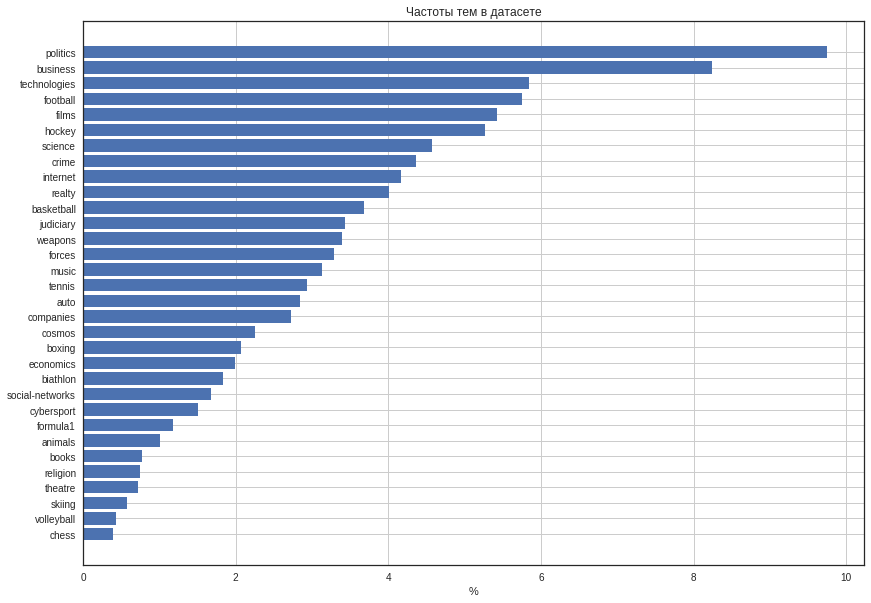

In [18]:
topics_freq = data.topic.value_counts(normalize=True, ascending=True)*100
plt.figure(figsize=(14,10))
plt.barh(range(len(topics_freq)), topics_freq.values)
plt.yticks(range(len(topics_freq)), topics_freq.index);
plt.xticks(np.arange(0, 11, 2));
plt.xlabel('%')
plt.grid(True)
plt.title('Частоты тем в датасете');

# Baseline

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer
from sklearn.svm import LinearSVC

from scipy.sparse import hstack

## Закодируем целевую переменную

In [20]:
le = LabelEncoder()
data.topic = le.fit_transform(data.topic)

## Разделим данные на train и validation

In [21]:
trainX = data.title + ' ' + data.text
trainX = np.swapaxes(np.vstack([trainX.values, data.url.values]), 0, 1)
trainY = data.topic.values

In [22]:
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.3, 
                                                    stratify=trainY, random_state=42)

## Вычислим tf-idf

In [23]:
%%time
tfidf_vectorizer = TfidfVectorizer(min_df=3, ngram_range=(1,2), lowercase=False).fit(trainX[:,0])

CPU times: user 57.8 s, sys: 480 ms, total: 58.3 s
Wall time: 58.2 s


In [24]:
len(tfidf_vectorizer.vocabulary_)

931858

In [25]:
X_train_tf = tfidf_vectorizer.transform(X_train[:,0])
X_test_tf = tfidf_vectorizer.transform(X_test[:,0])

## Обучим SVM

In [26]:
# clf = LinearSVC(C=1, max_iter=10000, loss='hinge', random_state=42)
clf = SGDClassifier(loss='hinge', n_iter=70, random_state=42, n_jobs=8, alpha=1e-5)

In [27]:
%%time
clf.fit(X_train_tf, y_train)
clf_prediciton = clf.predict(X_test_tf)
print('F1 score:', f1_score(y_test, clf_prediciton, average='macro'))
print('Accuracy:', accuracy_score(y_test, clf_prediciton))

F1 score: 0.888991801446
Accuracy: 0.878603362681
CPU times: user 7min 4s, sys: 72 ms, total: 7min 4s
Wall time: 1min 47s


## Построим нормализованную матрицу потерь

In [28]:
cm = confusion_matrix(y_test, clf_prediciton)
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

In [29]:
classes = [c for c in le.classes_]
df_cm = pd.DataFrame(np.round(cm_normalized, 2), columns=classes, index=classes)

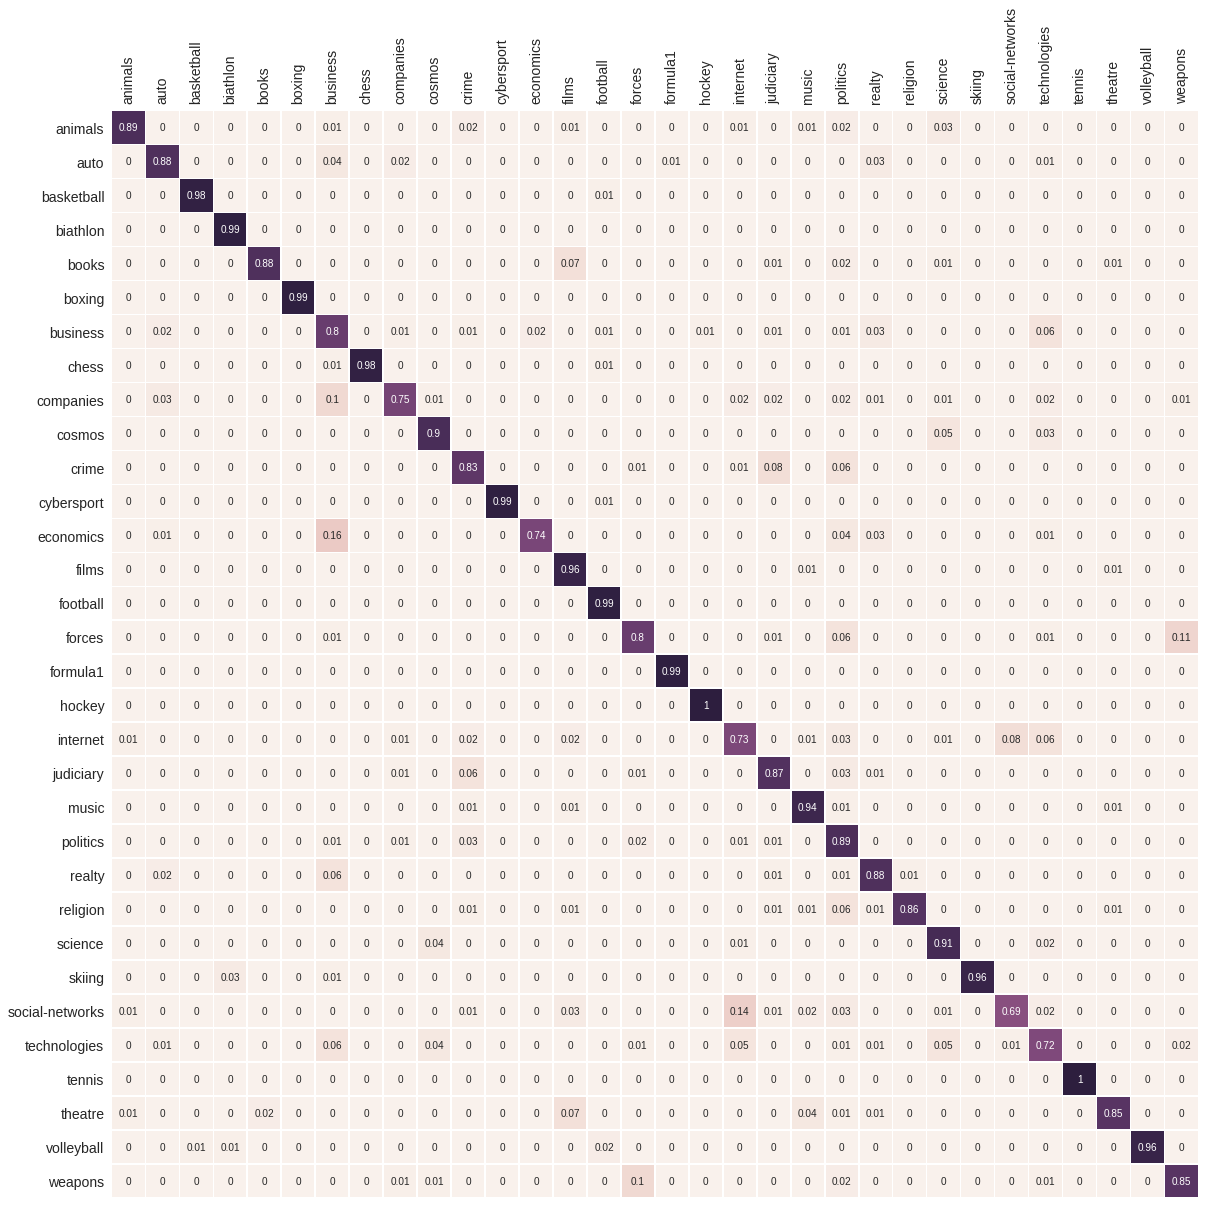

In [30]:
sns.set_context("notebook", font_scale=1.4);
plt.figure(figsize=(20, 20))
ax = sns.heatmap(df_cm, annot=True, linewidths=.5, fmt='g', cbar=False, square=True, annot_kws={"size": 10});
ax.xaxis.tick_top()
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);

In [31]:
class_scores = {}
for i in range(cm_normalized.shape[0]):
    class_scores[classes[i]] = cm_normalized[i,i]

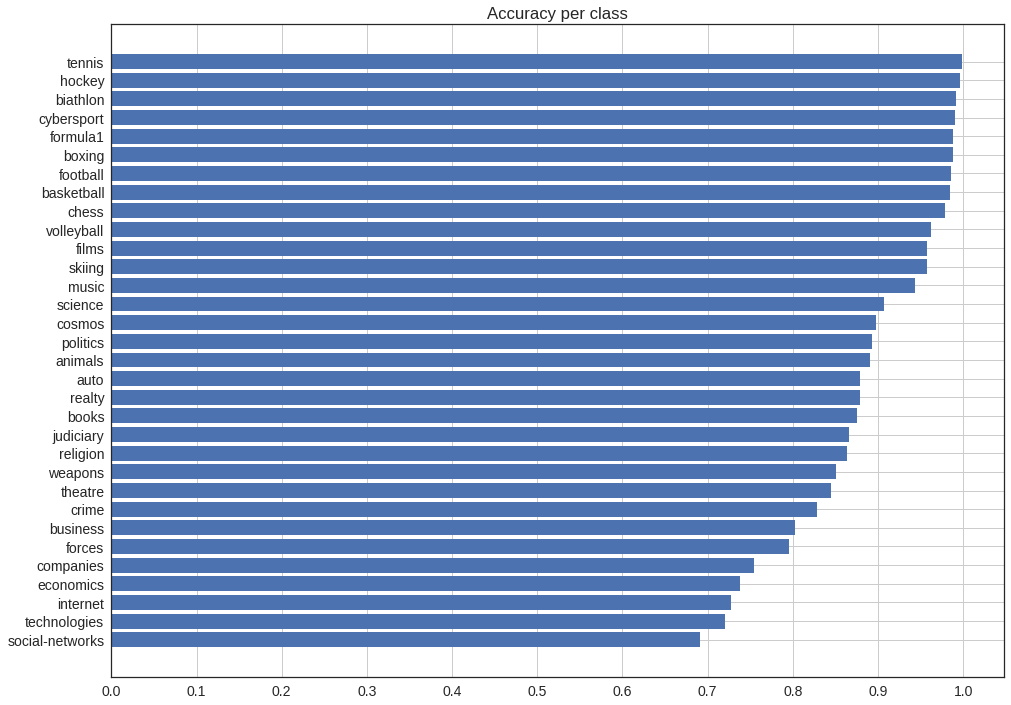

In [32]:
topics = []
scores = []
for topic, score in sorted(class_scores.items(), key=lambda x: x[1]):
    topics.append(topic)
    scores.append(score)
plt.figure(figsize=(16,12))
plt.barh(range(len(topics)), scores)
plt.yticks(range(len(topics)), topics);
plt.xticks(np.arange(0, 1.001, 0.1));
plt.grid(True)
plt.title('Accuracy per class');

## Посмотрим на ошибки классификации

In [33]:
for i, (true, pred) in enumerate(zip(y_test, clf_prediciton)):
    if true == le.transform(['technologies'])[0] and pred == le.transform(['realty'])[0]:
        print(X_test[i][1])

http://www.vedomosti.ru/technology/news/2015/12/31/623053-v-dubae
http://www.vedomosti.ru/technology/news/2015/02/27/gosduma-prinyala-zakon-o-zaprete-reklami-na-pamyatnikah-kulturi
https://lenta.ru/news/2015/12/23/robot/
https://lenta.ru/news/2015/09/21/ropebridge/
http://www.vedomosti.ru/technology/news/2016/01/27/625654-tokio-poezdov-magnitnoi-podushke
http://www.vedomosti.ru/technology/news/2011/11/24/ceul_priznan_samym_umnym_gorodom_mira
http://www.vedomosti.ru/technology/articles/2014/05/21/sobyanin-organizuet-dlya-moskvichej-ezhenedelnye-referendumy
http://www.vedomosti.ru/technology/news/2013/02/26/na_kosmodrome_vostochnyj_stroitelstvo_ostavshihsya_obektov
http://www.vedomosti.ru/technology/news/2016/02/04/626857-gabrelyanov
http://www.vedomosti.ru/technology/news/2013/01/17/v_kazhdoj_moskovskoj_shkole_poyavyatsya_16_kamer
http://www.vedomosti.ru/technology/news/2012/08/21/shojgu-raskritikoval-kachestvo-sotovoj-svyazi-v-podmoskove
http://www.vedomosti.ru/technology/news/2012/07/

## Выведем слова с максимальным весом внутри каждого класса

In [34]:
def print_top_K(vectorizer, clf, class_labels, k=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    top_words = {}
    for i, class_label in enumerate(class_labels):
        top_K = np.argsort(clf.coef_[i])[-k:]
        top_words[class_label] = [feature_names[j] for j in top_K]
#         print('%s: %s' % (class_label, ' '.join(feature_names[j] for j in top_K)))
    return pd.DataFrame(top_words)

In [35]:
print_top_K(tfidf_vectorizer, clf, le.classes_, k=10)

,animals,auto,basketball,biathlon,books,boxing,business,chess,companies,cosmos,...,realty,religion,science,skiing,social-networks,technologies,tennis,theatre,volleyball,weapons
0,крокодил,ford,рфб,домрачева,библиотека,алоян,туроператор,гроссмейстер,говориться пресс,вселенная,...,ипотечный,праздник,физик,сундбю,некоторые,nokia,сет,цискаридзе,маричев,авианосец
1,голубь,мобиль,единый лига,эстафета,комикс,боец,fifa,кирсан,миллион тонна,космический,...,москва,собор,биолог,легков,юзер,apple,кубок федерация,цирковой,факел,оборона россия
2,жить,осаго,баскетбольный,фуркад,издательство,лебзяк,олимпийский,магнус,миллиард кубометр,протон,...,жилищный,церковь,университет,сергей устюгов,микроблогер,инженер,open,запашный,вфв,министерство оборона
3,собака,автомобильный,центровой,шипулин,писательница,федерация бокс,гендиректор,шахматист,кубометр,космос,...,строительный,холокост,математик,нортуг,посмеяться,vimpelcom,шарапова,росгосцирк,суперлига,defense news
4,вольер,автопром,евробаскет,биатлонистка,произведение,мма,boeing,костенюк,миллиард,светить,...,аижк,митрополит,научный,вяльбе,twitter,оператор,шарапов,балет,федерация волейбол,беспилотник
5,животный,камаз,кубок европа,сбр,роман,поединок,uefa,карлсен,компания,мкс,...,строительство,христиан,журнал,fis,facebook,ростелеком,кубок дэвис,мюзикл,казанский,использоваться
6,питомец,авторынок,баскетбол,хохфильцен,литературный,поветкин,ритейлер,карякин,тысяча,астронавт,...,ипотека,муфтий,наука,лыжник,пользователь,wifi,теннис,постановка,алекно,jane
7,зоопарк,автопроизводитель,баскетболист,биатлон,книга,бой,rusal,шахматный,процент акция,спутник,...,жилье,храм,археолог,йохауг,пользователь сеть,контакт,корт,театральный,белогорье,тип
8,животное,автоваз,евролига,ibu,поэт,бокс,газпром,фид,ретейлер,астрофизик,...,жкх,святой,исследователь,лахти,вконтакте,мтс,теннисистка,театр,волейболист,defense
9,кличка,автомобиль,нба,биатлонист,писатель,боксер,оао,шахматы,процент,марс,...,недвижимость,патриарх,ученый,устюгов,соцсеть,робот,теннисист,спектакль,волейбол,миллиметровый


# Обучим Word2vec

In [36]:
from gensim.models import Word2Vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [37]:
corpus = pd.read_csv('./DATA_MANY_TOPICS.csv')[['text', 'topic']]

In [38]:
corpus.text = corpus.text.progress_apply(TEXT_PIPELINE)

100%|██████████| 188028/188028 [00:48<00:00, 3892.39it/s]


In [39]:
%%time
min_count = 3
vec_size = 250
window = 5

w2v = Word2Vec([text.split() for text in corpus.text],
               min_count=min_count, size=vec_size, window=window, hs=1, sg=1, workers=8)

2017-05-02 18:31:35,907 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2017-05-02 18:31:35,908 : INFO : collecting all words and their counts
2017-05-02 18:31:35,909 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-02 18:31:36,106 : INFO : PROGRESS: at sentence #10000, processed 1272552 words, keeping 42273 word types
2017-05-02 18:31:36,328 : INFO : PROGRESS: at sentence #20000, processed 2618710 words, keeping 62008 word types
2017-05-02 18:31:36,536 : INFO : PROGRESS: at sentence #30000, processed 3861867 words, keeping 77694 word types
2017-05-02 18:31:36,750 : INFO : PROGRESS: at sentence #40000, processed 5111744 words, keeping 90938 word types
2017-05-02 18:31:36,976 : INFO : PROGRESS: at sentence #50000, processed 6392161 words, keeping 112325 word types
2017-05-02 18:31:37,222 : INFO : PROGRESS: at sentence #60000, processed 7699467 words, keeping 133414 word types
2017-05-02 18:31:37,467 : INFO : PROGRESS: 

2017-05-02 18:32:35,223 : INFO : PROGRESS: at 3.38% examples, 80547 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:32:36,239 : INFO : PROGRESS: at 3.46% examples, 80656 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:32:37,467 : INFO : PROGRESS: at 3.55% examples, 80805 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:32:38,534 : INFO : PROGRESS: at 3.61% examples, 80652 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:32:39,619 : INFO : PROGRESS: at 3.68% examples, 80471 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:32:40,624 : INFO : PROGRESS: at 3.74% examples, 80417 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:32:41,711 : INFO : PROGRESS: at 3.82% examples, 80423 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:32:42,791 : INFO : PROGRESS: at 3.90% examples, 80270 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:32:43,871 : INFO : PROGRESS: at 3.96% examples, 80119 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:32:44,886 : INFO : PROGRESS: at 4.03% examples, 80054 words/s, in_qs

2017-05-02 18:34:02,335 : INFO : PROGRESS: at 8.90% examples, 77260 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:34:03,431 : INFO : PROGRESS: at 8.97% examples, 77210 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:34:04,583 : INFO : PROGRESS: at 9.03% examples, 77132 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:34:05,791 : INFO : PROGRESS: at 9.10% examples, 77024 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:34:06,908 : INFO : PROGRESS: at 9.19% examples, 77172 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:34:07,990 : INFO : PROGRESS: at 9.25% examples, 77132 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:34:09,113 : INFO : PROGRESS: at 9.31% examples, 77001 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:34:10,229 : INFO : PROGRESS: at 9.37% examples, 76946 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:34:11,339 : INFO : PROGRESS: at 9.44% examples, 76895 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:34:12,427 : INFO : PROGRESS: at 9.50% examples, 76856 words/s, in_qs

2017-05-02 18:35:31,515 : INFO : PROGRESS: at 15.51% examples, 75572 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:35:32,607 : INFO : PROGRESS: at 15.64% examples, 75553 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:35:33,687 : INFO : PROGRESS: at 15.76% examples, 75539 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:35:34,767 : INFO : PROGRESS: at 15.90% examples, 75524 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:35:35,811 : INFO : PROGRESS: at 16.05% examples, 75607 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:35:36,931 : INFO : PROGRESS: at 16.20% examples, 75621 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:35:38,021 : INFO : PROGRESS: at 16.33% examples, 75602 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:35:39,099 : INFO : PROGRESS: at 16.45% examples, 75589 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:35:40,183 : INFO : PROGRESS: at 16.58% examples, 75572 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:35:41,191 : INFO : PROGRESS: at 16.70% examples, 75581 word

2017-05-02 18:36:58,387 : INFO : PROGRESS: at 23.16% examples, 75460 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:36:59,471 : INFO : PROGRESS: at 23.22% examples, 75416 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:37:00,558 : INFO : PROGRESS: at 23.29% examples, 75403 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:37:01,628 : INFO : PROGRESS: at 23.35% examples, 75393 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:37:02,713 : INFO : PROGRESS: at 23.42% examples, 75379 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:37:03,794 : INFO : PROGRESS: at 23.48% examples, 75367 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:37:04,893 : INFO : PROGRESS: at 23.55% examples, 75352 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:37:05,971 : INFO : PROGRESS: at 23.62% examples, 75341 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:37:07,027 : INFO : PROGRESS: at 23.68% examples, 75335 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:37:08,047 : INFO : PROGRESS: at 23.76% examples, 75367 word

2017-05-02 18:38:24,987 : INFO : PROGRESS: at 28.47% examples, 74881 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:38:26,115 : INFO : PROGRESS: at 28.54% examples, 74864 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:38:27,199 : INFO : PROGRESS: at 28.60% examples, 74856 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:38:28,279 : INFO : PROGRESS: at 28.67% examples, 74849 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:38:29,367 : INFO : PROGRESS: at 28.73% examples, 74840 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:38:30,467 : INFO : PROGRESS: at 28.79% examples, 74829 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:38:31,559 : INFO : PROGRESS: at 28.86% examples, 74820 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:38:32,639 : INFO : PROGRESS: at 28.92% examples, 74813 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:38:33,724 : INFO : PROGRESS: at 28.99% examples, 74804 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:38:34,811 : INFO : PROGRESS: at 29.05% examples, 74796 word

2017-05-02 18:39:52,545 : INFO : PROGRESS: at 34.45% examples, 74514 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:39:53,627 : INFO : PROGRESS: at 34.58% examples, 74510 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:39:54,631 : INFO : PROGRESS: at 34.69% examples, 74497 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:39:55,677 : INFO : PROGRESS: at 34.82% examples, 74497 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:39:56,751 : INFO : PROGRESS: at 34.94% examples, 74494 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:39:57,827 : INFO : PROGRESS: at 35.07% examples, 74490 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:39:58,903 : INFO : PROGRESS: at 35.20% examples, 74486 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:39:59,967 : INFO : PROGRESS: at 35.33% examples, 74484 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:40:01,028 : INFO : PROGRESS: at 35.45% examples, 74483 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:40:02,087 : INFO : PROGRESS: at 35.59% examples, 74481 word

2017-05-02 18:41:18,366 : INFO : PROGRESS: at 42.47% examples, 74502 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:41:19,392 : INFO : PROGRESS: at 42.53% examples, 74504 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:41:20,463 : INFO : PROGRESS: at 42.59% examples, 74501 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:41:21,547 : INFO : PROGRESS: at 42.66% examples, 74495 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:41:22,647 : INFO : PROGRESS: at 42.73% examples, 74487 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:41:23,723 : INFO : PROGRESS: at 42.81% examples, 74483 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:41:24,783 : INFO : PROGRESS: at 42.88% examples, 74481 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:41:25,839 : INFO : PROGRESS: at 42.94% examples, 74480 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:41:26,915 : INFO : PROGRESS: at 43.00% examples, 74475 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:41:27,991 : INFO : PROGRESS: at 43.07% examples, 74471 word

2017-05-02 18:42:44,651 : INFO : PROGRESS: at 47.82% examples, 74339 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:42:45,715 : INFO : PROGRESS: at 47.89% examples, 74337 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:42:46,819 : INFO : PROGRESS: at 47.95% examples, 74331 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:42:47,926 : INFO : PROGRESS: at 48.02% examples, 74325 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:42:49,007 : INFO : PROGRESS: at 48.08% examples, 74321 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:42:50,095 : INFO : PROGRESS: at 48.15% examples, 74316 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:42:51,188 : INFO : PROGRESS: at 48.21% examples, 74311 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:42:52,271 : INFO : PROGRESS: at 48.28% examples, 74307 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:42:53,462 : INFO : PROGRESS: at 48.35% examples, 74291 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:42:54,567 : INFO : PROGRESS: at 48.41% examples, 74285 word

2017-05-02 18:44:12,111 : INFO : PROGRESS: at 53.09% examples, 74104 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:44:13,195 : INFO : PROGRESS: at 53.22% examples, 74101 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:44:14,255 : INFO : PROGRESS: at 53.35% examples, 74101 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:44:15,335 : INFO : PROGRESS: at 53.48% examples, 74098 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:44:16,395 : INFO : PROGRESS: at 53.60% examples, 74098 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:44:17,463 : INFO : PROGRESS: at 53.73% examples, 74096 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:44:18,543 : INFO : PROGRESS: at 53.86% examples, 74094 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:44:19,623 : INFO : PROGRESS: at 53.99% examples, 74091 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:44:20,907 : INFO : PROGRESS: at 54.13% examples, 74082 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:44:21,987 : INFO : PROGRESS: at 54.27% examples, 74080 word

2017-05-02 18:45:38,456 : INFO : PROGRESS: at 61.75% examples, 74102 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:45:39,531 : INFO : PROGRESS: at 61.81% examples, 74100 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:45:40,607 : INFO : PROGRESS: at 61.88% examples, 74097 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:45:41,659 : INFO : PROGRESS: at 61.94% examples, 74096 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:45:42,711 : INFO : PROGRESS: at 62.01% examples, 74096 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:45:43,903 : INFO : PROGRESS: at 62.10% examples, 74095 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:45:45,044 : INFO : PROGRESS: at 62.18% examples, 74098 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:45:46,103 : INFO : PROGRESS: at 62.25% examples, 74097 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:45:47,179 : INFO : PROGRESS: at 62.32% examples, 74095 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:45:48,239 : INFO : PROGRESS: at 62.39% examples, 74094 word

2017-05-02 18:47:05,019 : INFO : PROGRESS: at 67.15% examples, 74007 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:47:06,047 : INFO : PROGRESS: at 67.21% examples, 74009 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:47:07,107 : INFO : PROGRESS: at 67.26% examples, 73988 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:47:08,158 : INFO : PROGRESS: at 67.32% examples, 73977 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:47:09,179 : INFO : PROGRESS: at 67.38% examples, 73980 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:47:10,260 : INFO : PROGRESS: at 67.45% examples, 73978 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:47:11,311 : INFO : PROGRESS: at 67.52% examples, 73988 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:47:12,319 : INFO : PROGRESS: at 67.60% examples, 74013 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:47:13,370 : INFO : PROGRESS: at 67.66% examples, 74003 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:47:14,439 : INFO : PROGRESS: at 67.72% examples, 74001 word

2017-05-02 18:48:31,231 : INFO : PROGRESS: at 72.36% examples, 73876 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:48:32,309 : INFO : PROGRESS: at 72.42% examples, 73875 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:48:33,377 : INFO : PROGRESS: at 72.48% examples, 73874 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:48:34,483 : INFO : PROGRESS: at 72.55% examples, 73870 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:48:35,561 : INFO : PROGRESS: at 72.61% examples, 73868 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:48:36,645 : INFO : PROGRESS: at 72.68% examples, 73866 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:48:37,747 : INFO : PROGRESS: at 72.74% examples, 73863 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:48:38,855 : INFO : PROGRESS: at 72.80% examples, 73858 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:48:39,963 : INFO : PROGRESS: at 72.84% examples, 73854 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:48:41,019 : INFO : PROGRESS: at 72.90% examples, 73862 word

2017-05-02 18:49:57,079 : INFO : PROGRESS: at 81.02% examples, 73883 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:49:58,151 : INFO : PROGRESS: at 81.09% examples, 73881 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:49:59,215 : INFO : PROGRESS: at 81.16% examples, 73880 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:50:00,287 : INFO : PROGRESS: at 81.22% examples, 73879 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:50:01,351 : INFO : PROGRESS: at 81.29% examples, 73878 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:50:02,403 : INFO : PROGRESS: at 81.35% examples, 73877 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:50:03,471 : INFO : PROGRESS: at 81.42% examples, 73877 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:50:04,496 : INFO : PROGRESS: at 81.48% examples, 73878 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:50:05,579 : INFO : PROGRESS: at 81.53% examples, 73876 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:50:06,655 : INFO : PROGRESS: at 81.58% examples, 73875 word

2017-05-02 18:51:23,415 : INFO : PROGRESS: at 86.37% examples, 73836 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:51:24,543 : INFO : PROGRESS: at 86.43% examples, 73831 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:51:25,639 : INFO : PROGRESS: at 86.50% examples, 73829 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:51:26,691 : INFO : PROGRESS: at 86.56% examples, 73829 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:51:27,766 : INFO : PROGRESS: at 86.63% examples, 73827 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:51:28,841 : INFO : PROGRESS: at 86.69% examples, 73826 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:51:29,971 : INFO : PROGRESS: at 86.75% examples, 73822 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:51:31,083 : INFO : PROGRESS: at 86.82% examples, 73818 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:51:32,179 : INFO : PROGRESS: at 86.88% examples, 73816 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:51:33,271 : INFO : PROGRESS: at 86.95% examples, 73813 word

2017-05-02 18:52:50,525 : INFO : PROGRESS: at 91.62% examples, 73738 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:52:51,624 : INFO : PROGRESS: at 91.70% examples, 73743 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:52:52,829 : INFO : PROGRESS: at 91.76% examples, 73734 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:52:53,839 : INFO : PROGRESS: at 91.83% examples, 73737 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:52:55,027 : INFO : PROGRESS: at 91.89% examples, 73729 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:52:56,139 : INFO : PROGRESS: at 91.95% examples, 73726 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:52:57,239 : INFO : PROGRESS: at 92.02% examples, 73724 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:52:58,313 : INFO : PROGRESS: at 92.08% examples, 73723 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:52:59,418 : INFO : PROGRESS: at 92.15% examples, 73720 words/s, in_qsize 15, out_qsize 0
2017-05-02 18:53:00,619 : INFO : PROGRESS: at 92.21% examples, 73711 word

2017-05-02 18:54:13,095 : INFO : worker thread finished; awaiting finish of 4 more threads
2017-05-02 18:54:13,098 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-02 18:54:13,108 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-02 18:54:13,234 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-05-02 18:54:13,257 : INFO : worker thread finished; awaiting finish of 0 more threads
2017-05-02 18:54:13,257 : INFO : training on 101288160 raw words (99307227 effective words) took 1347.8s, 73683 effective words/s


CPU times: user 1h 29min 44s, sys: 948 ms, total: 1h 29min 45s
Wall time: 22min 40s


In [40]:
word_vectors = w2v.wv
del w2v

## Усредним вектора слов в каждой из новостей с весами tf-idf

In [44]:
word2tfidf = dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer.idf_))
vectorized_news = np.zeros((corpus.shape[0], vec_size), dtype="float32")
empty_news_id = []
for i in tqdm(range(corpus.shape[0])):
    words = [word for word in corpus.text.iloc[i].split()
             if word in word_vectors and word in word2tfidf]
    word_vecs = [word_vectors[word] for word in words]
    word_idfs = [word2tfidf[word]  for word in words]
    if word_vecs:
        vectorized_news[i,:] = np.average(word_vecs, axis=0, weights=word_idfs)
    else:
        vectorized_news[i,:] = np.zeros(vec_size)
        empty_news_id.append(i)

100%|██████████| 188028/188028 [01:13<00:00, 2544.96it/s]


In [54]:
data_w2v = pd.concat([pd.DataFrame(vectorized_news), corpus.topic], axis=1)

In [58]:
data_w2v = data_w2v[~data_w2v.index.isin(empty_news_id)]

In [59]:
data_w2v.topic = le.transform(data_w2v.topic)

In [97]:
data_w2v.head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,topic
0,0.179140,0.031803,-0.229366,-0.027541,-0.023368,-0.061698,0.072117,-0.027321,-0.010799,-0.018642,...,0.002978,0.045638,-0.053998,0.123584,0.118378,0.192139,0.011580,-0.016485,-0.025102,6
1,0.141140,-0.008756,-0.211733,0.011516,-0.062645,-0.046149,0.001939,0.018089,-0.113954,-0.010482,...,0.029392,0.110758,-0.036173,0.164326,0.090908,0.084765,0.113360,-0.066254,-0.080758,6
2,0.288942,0.081068,-0.321733,0.043719,-0.106183,-0.103078,0.152050,0.081993,-0.001439,0.132957,...,0.054613,0.009419,-0.013086,0.042420,0.114745,0.071835,0.045759,-0.011341,-0.026971,12
3,0.114858,0.023185,-0.084260,-0.059281,-0.125040,0.013174,0.142070,-0.119700,0.056121,-0.023655,...,-0.031938,0.015315,-0.066860,0.032759,0.131905,0.090094,0.060867,-0.026060,-0.083500,12
4,0.272408,0.035176,-0.232522,0.051137,0.003483,-0.096702,-0.014613,-0.028884,0.018045,0.025450,...,0.049606,0.160446,-0.147859,0.137412,0.005552,0.146921,-0.041022,-0.093277,-0.099768,27


## Обучим градиентный бустинг (LightGBM)

In [88]:
import lightgbm as lgb
import warnings
warnings.simplefilter('ignore')

In [89]:
X_train, X_test, y_train, y_test = train_test_split(data_w2v.iloc[:,:-1].values, data_w2v.iloc[:,-1], test_size=0.3,
                                                   stratify=data_w2v.iloc[:,-1], random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_test, y_test)

In [98]:
lgb_param = {
    'colsample_bytree': 0.8,
    'is_unbalance': False,
    'learning_rate': 0.05,
    'max_bin': 255,
    'max_depth': 7,
    'min_child_samples': 10,
    'min_child_weight': 5,
    'min_split_gain': 0,
    'nthread': 4,
    'num_leaves': 255,
    'objective': 'multiclass',
    'metric': 'multi_error',
    'is_training_metric': True,
    'num_class': len(le.classes_),
    'reg_alpha': 0,
    'reg_lambda': 0,
    'silent': True,
    'subsample': 0.8,
}

In [99]:
%%time
clf = lgb.train(lgb_param, lgb_train, num_boost_round=10000, valid_sets=[lgb_valid],
            early_stopping_rounds=50, verbose_eval=25)

Train until valid scores didn't improve in 50 rounds.
[25]	valid_0's multi_error: 0.193129
[50]	valid_0's multi_error: 0.183556
[75]	valid_0's multi_error: 0.175737
[100]	valid_0's multi_error: 0.17127
[125]	valid_0's multi_error: 0.166962
[150]	valid_0's multi_error: 0.16331
[175]	valid_0's multi_error: 0.160208
[200]	valid_0's multi_error: 0.158045
[225]	valid_0's multi_error: 0.156042
[250]	valid_0's multi_error: 0.15473
[275]	valid_0's multi_error: 0.153117
[300]	valid_0's multi_error: 0.151822
[325]	valid_0's multi_error: 0.150316
[350]	valid_0's multi_error: 0.14989
[375]	valid_0's multi_error: 0.148951
[400]	valid_0's multi_error: 0.14794
[425]	valid_0's multi_error: 0.147426
[450]	valid_0's multi_error: 0.146823
[475]	valid_0's multi_error: 0.146061
[500]	valid_0's multi_error: 0.145689
[525]	valid_0's multi_error: 0.145529
[550]	valid_0's multi_error: 0.144678
[575]	valid_0's multi_error: 0.144217
[600]	valid_0's multi_error: 0.143685
[625]	valid_0's multi_error: 0.143295
[650

In [ ]:
# print('F1 score:', f1_score(y_test, clf_prediciton, average='macro'))
# print('Accuracy:', accuracy_score(y_test, clf_prediciton))